In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("soybean_oil_prices.csv")
print("Original Dataset:")
print(df.head())

# Preprocessing the dataset
df = df.dropna()  # Drop rows with missing values
df = df.replace("#######", np.nan)  # Replace "#######" values with NaN
df = df.dropna()  # Drop rows with NaN values
df['Date'] = pd.to_datetime(df['Date'])  # Convert Date column to datetime format
df = df.set_index('Date')  # Set Date column as the index
df = df.astype(float)  # Convert all columns to float data type
print("Preprocessed Dataset:")
print(df.head())


Original Dataset:
         Date  Close/Last   Volume   Open   High    Low
0  03/24/2023       53.27  81987.0  52.35  53.88  51.48
1  03/23/2023       52.17  87675.0  54.56  54.77  51.28
2  03/22/2023       54.64  69471.0  56.35  56.44  54.45
3  03/21/2023       56.24  66524.0  58.02  58.24  56.08
4  03/20/2023       57.99  71495.0  57.33  58.39  56.04
Preprocessed Dataset:
            Close/Last   Volume   Open   High    Low
Date                                                
2023-03-24       53.27  81987.0  52.35  53.88  51.48
2023-03-23       52.17  87675.0  54.56  54.77  51.28
2023-03-22       54.64  69471.0  56.35  56.44  54.45
2023-03-21       56.24  66524.0  58.02  58.24  56.08
2023-03-20       57.99  71495.0  57.33  58.39  56.04


In [2]:
# Split the dataset into training and testing sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print("Training Dataset:")
print(train.head())
print("Testing Dataset:")
print(test.head())

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


Training Dataset:
            Close/Last   Volume   Open   High    Low
Date                                                
2023-03-24       53.27  81987.0  52.35  53.88  51.48
2023-03-23       52.17  87675.0  54.56  54.77  51.28
2023-03-22       54.64  69471.0  56.35  56.44  54.45
2023-03-21       56.24  66524.0  58.02  58.24  56.08
2023-03-20       57.99  71495.0  57.33  58.39  56.04
Testing Dataset:
            Close/Last   Volume   Open   High    Low
Date                                                
2016-02-25       30.91  59033.0  31.28  31.41  30.87
2016-02-24       31.19  65895.0  31.32  31.26  30.70
2016-02-23       31.01  64151.0  31.53  31.77  30.96
2016-02-19       31.63  45181.0  31.63  32.18  31.56
2016-02-18       32.06  33568.0  32.19  32.25  31.98


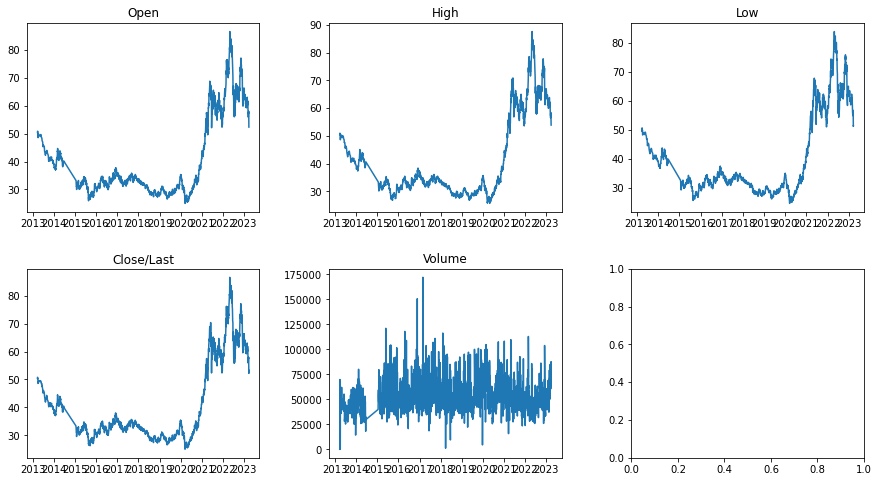

In [3]:
# Create a new dataframe for visualization
df_visual = df[['Open', 'High', 'Low', 'Close/Last', 'Volume']]

# Visualize the data
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.ravel()
for i, col in enumerate(df_visual.columns):
    axes[i].plot(df_visual.index, df_visual[col])
    axes[i].set_title(col)
plt.show()

In [4]:
# Define the number of time steps and features
n_steps = 30
n_features = 5

# Create a function to generate batches for the LSTM model
def generate_batches(data, n_steps, n_features):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :n_features])
        y.append(data[i, -1])
    X, y = np.array(X), np.array(y)
    return X, y

# Generate batches for the training and testing sets
X_train, y_train = generate_batches(train_scaled, n_steps, n_features)
X_test, y_test = generate_batches(test_scaled, n_steps, n_features)

In [5]:
# Define the LSTM model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


2023-04-01 20:01:26.805986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 20:01:31.805310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
110/110 [==============================] - 7s 28ms/step - loss: 0.0109 - val_loss: 7.3261e-04
Epoch 2/50
110/110 [==============================] - 2s 21ms/step - loss: 0.0038 - val_loss: 8.7379e-04
Epoch 3/50
110/110 [==============================] - 2s 22ms/step - loss: 0.0029 - val_loss: 5.8523e-04
Epoch 4/50
110/110 [==============================] - 2s 22ms/step - loss: 0.0021 - val_loss: 5.5623e-04
Epoch 5/50
110/110 [==============================] - 2s 22ms/step - loss: 0.0023 - val_loss: 9.1822e-04
Epoch 6/50
110/110 [==============================] - 2s 21ms/step - loss: 0.0023 - val_loss: 4.9067e-04
Epoch 7/50
110/110 [==============================] - 2s 21ms/step - loss: 0.0019 - val_loss: 4.7842e-04
Epoch 8/50
110/110 [==============================] - 2s 21ms/step - loss: 0.0020 - val_loss: 7.6905e-04
Epoch 9/50
110/110 [==============================] - 2s 21ms/step - loss: 0.0019 - val_loss: 5.4653e-04
Epoch 10/50
110/110 [==============================] - 

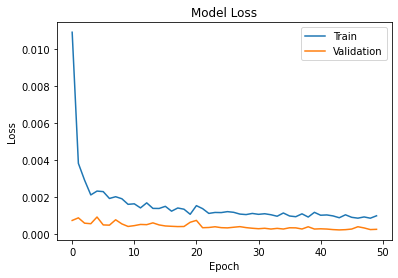

In [6]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [7]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Calculate the root mean squared error
train_rmse = np.sqrt(np.mean(np.power((y_train - train_predict), 2)))
test_rmse = np.sqrt(np.mean(np.power((y_test - test_predict), 2)))
print("\nTraining RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

13/13 [==============================] - 0s 7ms/step

Training RMSE: 0.3648004790906717
Testing RMSE: 0.1489824696971599


In [8]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)

print('Loss:', test_loss)

13/13 [==============================] - 1s 7ms/step - loss: 2.5288e-04
Loss: 0.0002528752665966749


In [12]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

print("Accuracy: ", r2)

13/13 [==============================] - 0s 8ms/step
Accuracy:  0.9763902491757082
